In [1]:
import numpy as np
import skimage.morphology
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
import math
import matplotlib.pyplot as plt

In [2]:
import cv2

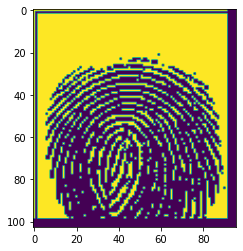

In [3]:
#IMage Binarization
# read the image file
img = cv2.imread('C:/Users/User/Downloads/Compressed/SOCOFing/Real/1__M_Left_index_finger.BMP', 2) 
  
ret, bw_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
  
# converting to its binary form
bw = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
  
cv2.imshow("Binary", bw_img)
plt.imshow(bw_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [4]:
import cv2
import numpy as np
import skimage.morphology
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
import math

class MinutiaeFeature(object):
    def __init__(self, locX, locY, Orientation, Type):
        self.locX = locX
        self.locY = locY
        self.Orientation = Orientation
        self.Type = Type

class FingerprintFeatureExtractor(object):
    def __init__(self):
        self._mask = []
        self._skel = []
        self.minutiaeTerm = []
        self.minutiaeBif = []

    def __skeletonize(self, img):
        img = np.uint8(img > 128)
        self._skel = skimage.morphology.skeletonize(img)
        self._skel = np.uint8(self._skel) * 255
        self._mask = img * 255

    def __computeAngle(self, block, minutiaeType):
        angle = []
        (blkRows, blkCols) = np.shape(block)
        CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
        if (minutiaeType.lower() == 'termination'):
            sumVal = 0
            for i in range(blkRows):
                for j in range(blkCols):
                    if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                        angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                        sumVal += 1
                        if (sumVal > 1):
                            angle.append(float('nan'))
            return (angle)

        elif (minutiaeType.lower() == 'bifurcation'):
            (blkRows, blkCols) = np.shape(block)
            CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
            angle = []
            sumVal = 0
            for i in range(blkRows):
                for j in range(blkCols):
                    if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                        angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                        sumVal += 1
            if (sumVal != 3):
                angle.append(float('nan'))
            return (angle)

    def __getTerminationBifurcation(self):
        self._skel = self._skel == 255
        (rows, cols) = self._skel.shape
        self.minutiaeTerm = np.zeros(self._skel.shape)
        self.minutiaeBif = np.zeros(self._skel.shape)

        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                if (self._skel[i][j] == 1):
                    block = self._skel[i - 1:i + 2, j - 1:j + 2]
                    block_val = np.sum(block)
                    if (block_val == 2):
                        self.minutiaeTerm[i, j] = 1
                    elif (block_val == 4):
                        self.minutiaeBif[i, j] = 1

        self._mask = convex_hull_image(self._mask > 0)
        self._mask = erosion(self._mask, square(5))  # Structuing element for mask erosion = square(5)
        self.minutiaeTerm = np.uint8(self._mask) * self.minutiaeTerm

    def __removeSpuriousMinutiae(self, minutiaeList, img, thresh):
        img = img * 0
        SpuriousMin = []
        numPoints = len(minutiaeList)
        D = np.zeros((numPoints, numPoints))
        for i in range(1,numPoints):
            for j in range(0, i):
                (X1,Y1) = minutiaeList[i]['centroid']
                (X2,Y2) = minutiaeList[j]['centroid']

                dist = np.sqrt((X2-X1)**2 + (Y2-Y1)**2)
                D[i][j] = dist
                if(dist < thresh):
                    SpuriousMin.append(i)
                    SpuriousMin.append(j)

        SpuriousMin = np.unique(SpuriousMin)
        for i in range(0,numPoints):
            if(not i in SpuriousMin):
                (X,Y) = np.int16(minutiaeList[i]['centroid'])
                img[X,Y] = 1

        img = np.uint8(img)
        return(img)

    def __cleanMinutiae(self, img):
        self.minutiaeTerm = skimage.measure.label(self.minutiaeTerm, connectivity=2)
        RP = skimage.measure.regionprops(self.minutiaeTerm)
        self.minutiaeTerm = self.__removeSpuriousMinutiae(RP, np.uint8(img), 10)

    def __performFeatureExtraction(self):
        FeaturesTerm = []
        self.minutiaeTerm = skimage.measure.label(self.minutiaeTerm, connectivity=2)
        RP = skimage.measure.regionprops(np.uint8(self.minutiaeTerm))

        WindowSize = 2  # --> For Termination, the block size must can be 3x3, or 5x5. Hence the window selected is 1 or 2
        FeaturesTerm = []
        for num, i in enumerate(RP):
            (row, col) = np.int16(np.round(i['Centroid']))
            block = self._skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
            angle = self.__computeAngle(block, 'Termination')
            if(len(angle) == 1):
                FeaturesTerm.append(MinutiaeFeature(row, col, angle, 'Termination'))

        FeaturesBif = []
        self.minutiaeBif = skimage.measure.label(self.minutiaeBif, connectivity=2)
        RP = skimage.measure.regionprops(np.uint8(self.minutiaeBif))
        WindowSize = 1  # --> For Bifurcation, the block size must be 3x3. Hence the window selected is 1
        for i in RP:
            (row, col) = np.int16(np.round(i['Centroid']))
            block = self._skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
            angle = self.__computeAngle(block, 'Bifurcation')
            if(len(angle) == 3):
                FeaturesBif.append(MinutiaeFeature(row, col, angle, 'Bifurcation'))
        return (FeaturesTerm, FeaturesBif)

    def extractMinutiaeFeatures(self, img):
        self.__skeletonize(img)

        self.__getTerminationBifurcation()

        self.__cleanMinutiae(img)

        FeaturesTerm, FeaturesBif = self.__performFeatureExtraction()
        return(FeaturesTerm, FeaturesBif)

    def showResults(self, FeaturesTerm, FeaturesBif):
        
        (rows, cols) = self._skel.shape
        DispImg = np.zeros((rows, cols, 3), np.uint8)
        DispImg[:, :, 0] = 255*self._skel
        DispImg[:, :, 1] = 255*self._skel
        DispImg[:, :, 2] = 255*self._skel

        for idx, curr_minutiae in enumerate(FeaturesTerm):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
            skimage.draw.set_color(DispImg, (rr, cc), (0, 0, 255))

        for idx, curr_minutiae in enumerate(FeaturesBif):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
            skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0))
        
        cv2.imshow('output', DispImg)
        cv2.waitKey(0)
        plt.imshow(DispImg)


def extract_minutiae_features(img, showResult=False):
    feature_extractor = FingerprintFeatureExtractor()
    FeaturesTerm, FeaturesBif = feature_extractor.extractMinutiaeFeatures(img)

    if(showResult):
        feature_extractor.showResults(FeaturesTerm, FeaturesBif)

    return(FeaturesTerm, FeaturesBif)

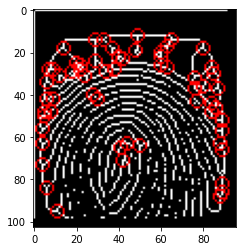

In [5]:
#import fingerprint_feature_extractor
img = cv2.imread('C:/Users/User/Downloads/Compressed/SOCOFing/Real/1__M_Left_index_finger.BMP', 0) 
plt.imshow(img)
FeaturesTerminations, FeaturesBifurcations = extract_minutiae_features(img, showResult=True)

[[ 3  3  2]
 [ 2  3 -2]]
U:  [[ 0.7815437 -0.6238505]
 [ 0.6238505  0.7815437]]
Singular array [5.54801894 2.86696457]
V^{T} [[ 0.64749817  0.7599438   0.05684667]
 [-0.10759258  0.16501062 -0.9804057 ]
 [-0.75443354  0.62869461  0.18860838]]
[[ 0.11462451  0.04347826]
 [ 0.07114625  0.13043478]
 [ 0.22134387 -0.26086957]]


<ipython-input-5-423e8145034a>:46: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  gray_cat = rgb2gray(cat)


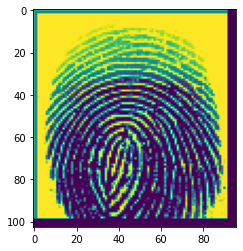

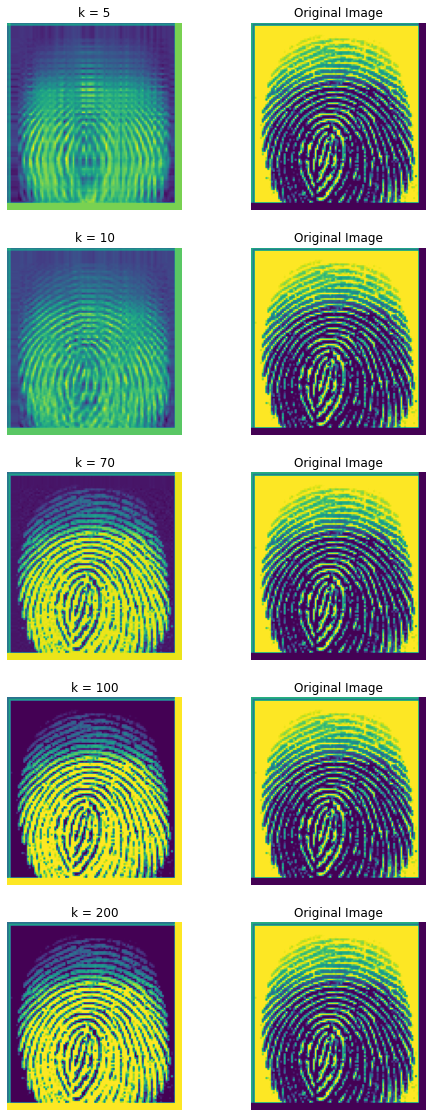

In [5]:
# Imports

import numpy as np
from scipy.linalg import svd

"""
Singular Value Decomposition
"""
# define a matrix
X = np.array([[3, 3, 2], [2,3,-2]])
print(X)
# perform SVD
U, singular, V_transpose = svd(X)
# print different components
print("U: ",U)
print("Singular array",singular)
print("V^{T}",V_transpose)

"""
Calculate Pseudo inverse
"""
# inverse of singular matrix is just the reciprocal of each element
singular_inv = 1.0 / singular
# create m x n matrix of zeroes and put singular values in it
s_inv = np.zeros(X.shape)
s_inv[0][0]= singular_inv[0]
s_inv[1][1] =singular_inv[1]
# calculate pseudoinverse
M = np.dot(np.dot(V_transpose.T,s_inv.T),U.T)
print(M)

"""
SVD on image compression
"""

import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray
import cv2


cat = cv2.imread('C:/Users/User/Downloads/Compressed/SOCOFing/Real/1__M_Left_index_finger.BMP', 0)
plt.imshow(cat)
# convert to grayscale
gray_cat = rgb2gray(cat)

# calculate the SVD and plot the image
U,S,V_T = svd(gray_cat, full_matrices=False)
S = np.diag(S)
fig, ax = plt.subplots(5, 2, figsize=(8, 20))

curr_fig=0
for r in [5, 10, 70, 100, 200]:
    cat_approx =U[:, :r] @ S[0:r, :r] @ V_T[:r, :]
    ax[curr_fig][0].imshow(256-cat_approx)
    ax[curr_fig][0].set_title("k = "+str(r))
    ax[curr_fig,0].axis('off')
    ax[curr_fig][1].set_title("Original Image")
    ax[curr_fig][1].imshow(gray_cat)
    ax[curr_fig,1].axis('off')
    curr_fig +=1
plt.show()
